Note: Deep Learning with PyTorch: A 60 Minute Blitz
====
---
<https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html>

Lesson4: Training a classifier
---

**Question1:** What is 'num_workser'   
**Question2:** Why after training, only one class got trained?  

**4.1 What about data**

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.
- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, eight raw Python or Cython based loading, or NLTK and SpaCy are useful.

Specifially for vision, we have created a package called trochvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc, and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`. 

**4.2 Steps of training an imgage classifier**
1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`. 
2. Define a Convolutional Neural Network.  
3. Define a loss function. 
4. Train the network on the training data
5. Test the network on the test data

Step1/5 Loading and normalizing CIFAR10
----

In [44]:
import torch
import torchvision
import torchvision.transforms as transforms

In [49]:
# The output of torchvision datasets are PILImage images of range[0,1]. 
# We transform them to Tensors of normalized range [-1 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root= './data',train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,
                                         shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,
                                      download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,
                                          shuffle=False, num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog',
          'horse', 'ship','truck')


Files already downloaded and verified
Files already downloaded and verified


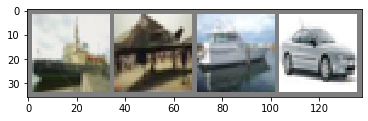

 ship plane  ship   car


In [52]:
# Let us show some of the training images, for fun.
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Step2/5 Define a Convolutional Neual Network
----

In [55]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

Step3/5. Define a Loss function and optimizer
---

In [53]:
# Let's use a Classification Cross-Entropy loss and SGD momentum. 
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Step4/5: Trian the network
---

In [56]:
# This is when things start to get interesting. We simply have to loop 
# over our data iterator, and feef the inputs to the network and optimizer.
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % 
                 (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
            
print('Finished Training')
    
        

[1,  2000] loss: 2.305
[1,  4000] loss: 2.304
[1,  6000] loss: 2.304
[1,  8000] loss: 2.302
[1, 10000] loss: 2.304
[1, 12000] loss: 2.305
[2,  2000] loss: 2.304
[2,  4000] loss: 2.304
[2,  6000] loss: 2.304
[2,  8000] loss: 2.304
[2, 10000] loss: 2.303
[2, 12000] loss: 2.304
Finished Training


In [57]:
# let's quickly save our trained model:
PATH = './cifar_net.pth'
torch.save(net.state_dict(),PATH)

Step5/5: Test the network on the test data
---

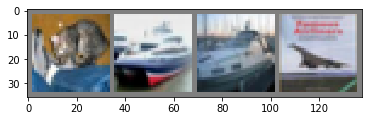

GroundTruth:   cat  ship  ship plane


In [58]:
# First, let us display an image from the test set to get familiar.
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [59]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [61]:
outputs = net(images)
# The outputs are enegies for the 10 classes.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs,1)
print('Predicted:', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))


Predicted:  bird  bird  bird  bird


In [63]:
# Let us look at how the netowrk performs on the whole dataset.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' %(
      100*correct/total))

Accuracy of the network on the 10000 test images: 10 %


In [65]:
# What are the classes that performed well, and the classes that did not 
# perform well:
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (
          classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane:  0 %
Accuracy of   car:  0 %
Accuracy of  bird: 100 %
Accuracy of   cat:  0 %
Accuracy of  deer:  0 %
Accuracy of   dog:  0 %
Accuracy of  frog:  0 %
Accuracy of horse:  0 %
Accuracy of  ship:  0 %
Accuracy of truck:  0 %


**Training on GPU**

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.    
Let's first define our device as the first visible cuda device if we have CUDA available:

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
net.to(device)

In [ ]:
# Remember that you will have to send the inputs and targets at every step
# to the GPU too:
inputs, labels = data[0].to(device), data[1].to(device)